<a href="https://colab.research.google.com/github/rishavk77-bit/VLG/blob/main/updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
import os

# Define the data directory
data_dir = '/content/drive/MyDrive/vlg-dataset'
a = "/content/drive/MyDrive/vlg-dataset"
# List the classes
classes = os.listdir(data_dir + "/train")

# Check for and remove '.DS_Store'
if '.DS_Store' in classes:
    os.remove(os.path.join(data_dir + "/train", '.DS_Store'))
    classes.remove('.DS_Store')  # Update the list after removal

print("Cleaned classes:", classes)

Cleaned classes: ['hippopotamus', 'giant+panda', 'raccoon', 'killer+whale', 'humpback+whale', 'pig', 'antelope', 'dalmatian', 'persian+cat', 'siamese+cat', 'leopard', 'giraffe', 'dolphin', 'zebra', 'polar+bear', 'blue+whale', 'mouse', 'beaver', 'otter', 'seal', 'spider+monkey', 'rat', 'chihuahua', 'ox', 'tiger', 'hamster', 'buffalo', 'wolf', 'grizzly+bear', 'bobcat', 'german+shepherd', 'weasel', 'mole', 'skunk', 'walrus', 'bat', 'deer', 'cow', 'lion', 'elephant']


In [4]:
from collections import defaultdict


train_dir = '/content/drive/MyDrive/vlg-dataset/train'


class_counts = defaultdict(int)


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        class_counts[class_name] = len(os.listdir(class_path))


for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")


total_images = sum(class_counts.values())
print(f"\nVerified total images: {total_images}")


Class: hippopotamus, Number of images: 250
Class: giant+panda, Number of images: 250
Class: raccoon, Number of images: 250
Class: killer+whale, Number of images: 250
Class: humpback+whale, Number of images: 250
Class: pig, Number of images: 250
Class: antelope, Number of images: 250
Class: dalmatian, Number of images: 250
Class: persian+cat, Number of images: 250
Class: siamese+cat, Number of images: 250
Class: leopard, Number of images: 250
Class: giraffe, Number of images: 250
Class: dolphin, Number of images: 250
Class: zebra, Number of images: 250
Class: polar+bear, Number of images: 250
Class: blue+whale, Number of images: 174
Class: mouse, Number of images: 185
Class: beaver, Number of images: 193
Class: otter, Number of images: 250
Class: seal, Number of images: 250
Class: spider+monkey, Number of images: 250
Class: rat, Number of images: 256
Class: chihuahua, Number of images: 250
Class: ox, Number of images: 250
Class: tiger, Number of images: 250
Class: hamster, Number of ima

In [5]:

transform = tt.Compose([
    tt.Resize((224, 224)),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(15),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
dataset = ImageFolder(train_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False , num_workers=4)


In [8]:
from torchvision.datasets import DatasetFolder
from PIL import Image

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.test_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]


test_dir = '/content/drive/MyDrive/vlg-dataset/test'
test_transform = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Number of test images: {len(test_dataset)}")


Number of test images: 3052


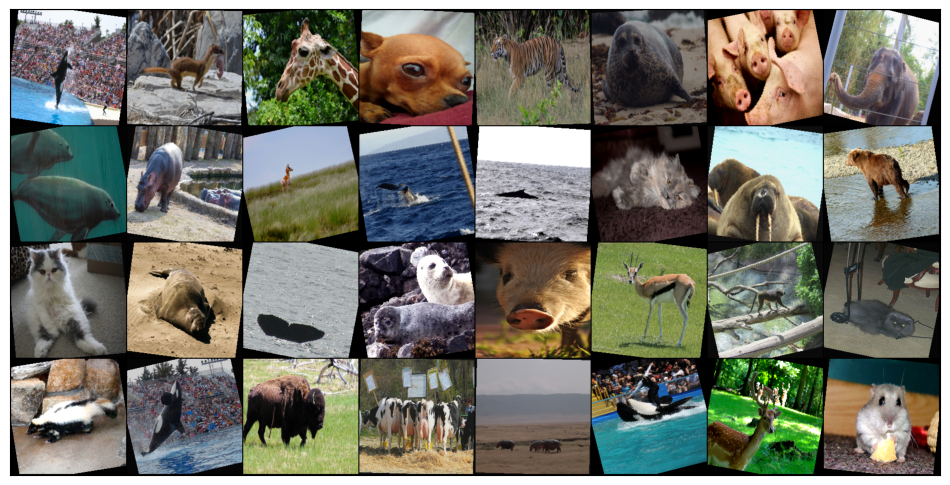

In [9]:

# Define stats for normalization
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Denormalization function
def denormalize(images, means, stds):
    means = torch.tensor(means, device=images.device).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds, device=images.device).reshape(1, 3, 1, 1)
    return images * stds + means


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).cpu().clamp(0, 1))
        plt.show()
        break


show_batch(train_loader)


In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [13]:
from torchvision import models


model = models.resnet50(pretrained=True)


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 40)


model = to_device(model, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


In [14]:
from torch.optim import Adam

# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = Adam(model.parameters(), lr=0.001)

#lr schedule
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=False)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        images, labels = to_device((images, labels), device)


        outputs = model(images)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:

            images, labels = to_device((images, labels), device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Epoch 1/10
Train Loss: 2.6699, Train Accuracy: 0.2588
Validation Loss: 2.3282, Validation Accuracy: 0.3257
Best model saved!
Epoch 2/10
Train Loss: 1.9554, Train Accuracy: 0.4246
Validation Loss: 2.5793, Validation Accuracy: 0.3759
Best model saved!
Epoch 3/10
Train Loss: 1.6459, Train Accuracy: 0.5027
Validation Loss: 1.4821, Validation Accuracy: 0.5476
Best model saved!
Epoch 4/10
Train Loss: 1.3974, Train Accuracy: 0.5745
Validation Loss: 1.4119, Validation Accuracy: 0.5759
Best model saved!
Epoch 5/10
Train Loss: 1.2454, Train Accuracy: 0.6118
Validation Loss: 1.5860, Validation Accuracy: 0.5492
Epoch 6/10
Train Loss: 1.1181, Train Accuracy: 0.6499
Validation Loss: 1.3209, Validation Accuracy: 0.6031
Best model saved!
Epoch 7/10
Train Loss: 1.0357, Train Accuracy: 0.6804
Validation Loss: 1.3821, Validation Accuracy: 0.5796
Epoch 8/10
Train Loss: 0.9109, Train Accuracy: 0.7131
Validation Loss: 1.2327, Validation Accuracy: 0.6319
Best model saved!
Epoch 9/10
Train Loss: 0.8502, Train

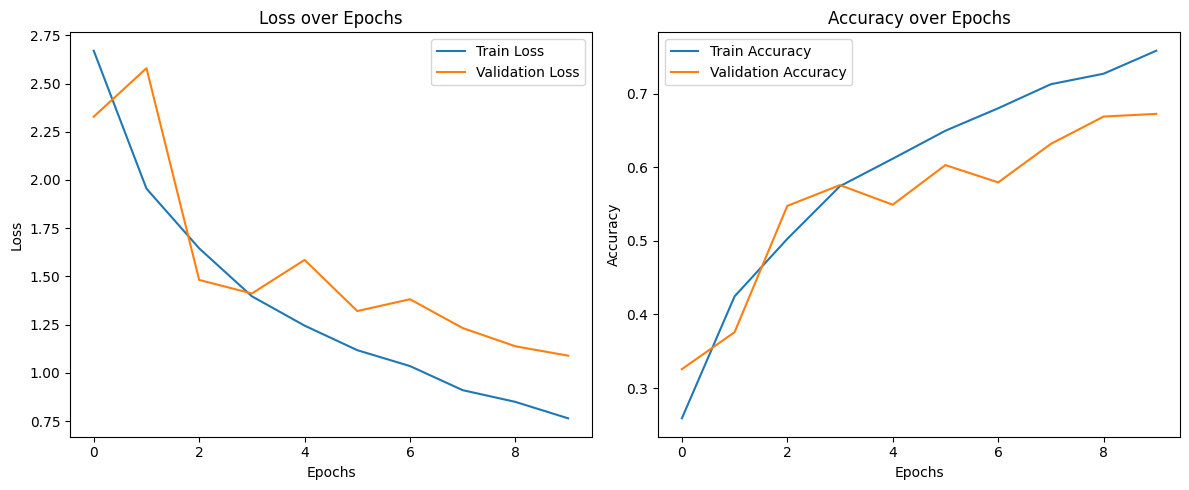

In [16]:

best_val_acc = 0.0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train the model
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate the model
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the model with the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")

    # Step the scheduler
    scheduler.step(val_acc)

# Plot training and validation loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


## COMPLETED

In [17]:
best_model = models.resnet50(pretrained=False)  # Initialize model structure
best_model.fc = nn.Linear(num_features, 40)    # Match your modified model structure
best_model.load_state_dict(torch.load("/content/best_model.pth"))
best_model = to_device(best_model, device)

# Evaluate on test set
def evaluate_test(model, test_loader):
    model.eval()
    predictions = []
    image_files = []
    with torch.no_grad():
        for images, file_names in test_loader:
            images = to_device(images, device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            image_files.extend(file_names)
    return list(zip(image_files, predictions))

test_results = evaluate_test(best_model, test_loader)
print(f"Test set predictions: {test_results[:10]}")  # Print a sample


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-17-44b5b9106627>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

Test set predictions: [('00001.jpg', 23), ('00002.jpg', 3), ('00003.jpg', 23), ('00004.jpg', 25), ('00005.jpg', 7), ('00006.jpg', 26), ('00007.jpg', 21), ('00008.jpg', 21), ('00009.jpg', 12), ('00010.jpg', 21)]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


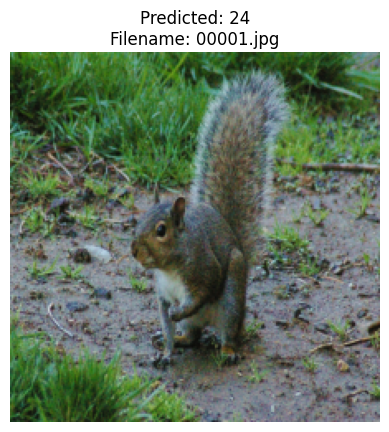

In [23]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def plot_image_and_prediction(model, test_loader, device, class_names):

    images, filenames = next(iter(test_loader))


    images = to_device(images, device)


    outputs = model(images)
    _, preds = torch.max(outputs, 1)


    img = images[0].cpu().numpy().transpose((1, 2, 0))
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  #
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title(f"Predicted: {class_names[preds[0]]}\nFilename: {filenames[0]}")
    plt.show()


class_names = [str(i) for i in range(1, 41)]


plot_image_and_prediction(model, test_loader, device, class_names)


In [22]:
classes[25]

'hamster'

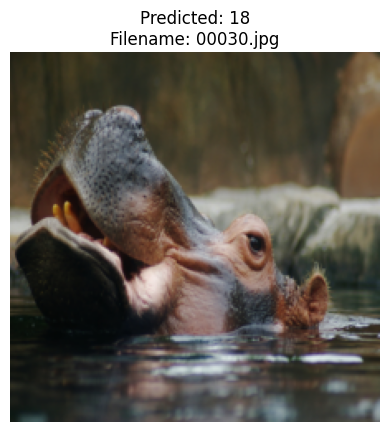

In [71]:
# Function to plot the image and print predicted class for any image in the test set
def plot_image_and_prediction(model, test_loader, device, class_names, image_index=0):

    images, filenames = next(iter(test_loader))


    images = to_device(images, device)
    ind = 29

    outputs = model(images)
    _, preds = torch.max(outputs, 1)


    img = images[ind].cpu().numpy().transpose((1, 2, 0))
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[preds[ind]]}\nFilename: {filenames[ind]}")
    plt.show()


class_names = [str(i) for i in range(1, 41)]

# Example Usage: Plot and print prediction for the second image in the batch
plot_image_and_prediction(model, test_loader, device, class_names, image_index=1)


In [40]:
# Print the class names that the model was trained on
train_class_names = dataset.classes
print("Training class names:", train_class_names)


Training class names: ['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'german+shepherd', 'giant+panda', 'giraffe', 'grizzly+bear', 'hamster', 'hippopotamus', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'raccoon', 'rat', 'seal', 'siamese+cat', 'skunk', 'spider+monkey', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


In [72]:
train_class_names[17]

'hippopotamus'

In [69]:
# Function to evaluate test set and map predictions to training class names
def evaluate_test_with_class_names(model, test_loader, class_names):
    model.eval()
    predictions = []
    image_files = []
    with torch.no_grad():
        for images, file_names in test_loader:
            images = to_device(images, device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            image_files.extend(file_names)

    # Map predictions to class names
    predictions_mapped = [(file_name, class_names[pred]) for file_name, pred in zip(image_files, predictions)]

    return predictions_mapped

# Get predictions for the test set mapped to class names
test_results = evaluate_test_with_class_names(best_model, test_loader, train_class_names)

# Print the first 10 results (file names and predicted class names)
print(f"Test set predictions mapped to class names: {test_results[35]}")


Test set predictions mapped to class names: ('00036.jpg', 'bat')


In [73]:
print(f"Test set predictions mapped to class names: {test_results[29]}")


Test set predictions mapped to class names: ('00030.jpg', 'hippopotamus')
